### Preliminaries

You have to install numpy, pandas, seaborn and numba.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from numba import njit

sns.set_style("whitegrid")

## Analytical Solution

In [2]:
def alpha_one(alpha, beta):
    """Alpha one as computed in exercise 1.8
        
    Args:
        alpha (float): Capital exponent in production function
            F(k, l) = A * k ** alpha; 0 <= alpha.
        beta (float): Discount factor in household problem; 0 < beta < 1.
        
    Returns:
        out (float): Value of alpha_0.
        
    """
    return alpha / (1 - alpha * beta)

In [3]:
def alpha_zero(beta, technology, alpha_1):
    """Alpha zero as computed in exercise 1.8
    
    This computes alpha zero dependent in alpha_1. In principle alpha_0
    can be formulated without a dependence on alpha_1 but since I am bad
    in "algebra" I avoid taking the risk of making an error.
    
    Args:
        beta (float): Discount factor in household problem; 0 < beta < 1.
        technology (float): Technology parameter of production function (A) in 
            F(k, l) = A * k ** alpha; 0 <= A.
        alpha_one (float): The computed coefficient using function ``alpha_one``.
        
    Returns:
        out (float): Value of alpha_0.
    
    """
    alpha_one_beta = alpha_1 * beta
    out = alpha_one_beta * np.log(alpha_one_beta) + (1 + alpha_one_beta) * np.log(
        technology / (1 + alpha_one_beta)
    )
    out /= 1 - beta
    return out

In [4]:
def value_function_guess(capital, alpha_0, alpha_1):
    """Value function guess.
    
    Args:
        capital (float or np.ndarray): Capital.
        alpha_0 (float): Coefficient.
        alpha_1 (float): Coefficient.
        
    
    Returns:
        value (float or np.ndarray): Value given capital.
        
    """
    value = alpha_0 + alpha_1 * np.log(capital)
    return value

## Numerical Solution

#### Auxiliary Functions:

In [5]:
@njit
def production_func(capital, technology, alpha):
    """Production function.
    
    F(k, l) = A * k ** alpha, where k denotes capital.
    
    Args:
        capital (float or np.ndarray): Capital.
        technology (float): Technology parameter of production function (A) in 
            F(k, l) = A * k ** alpha; 0 <= A.
        alpha (float): Capital exponent in production function.
            F(k, l) = A * k ** alpha; 0 <= alpha.
    
    Returns:
        production (float or np.ndarray): Production level.
        
    """
    production = technology * capital ** alpha
    return production

In [6]:
@njit
def utility_func(capital_today, capital_tomorrow, alpha, technology):
    """Utility function only dependent on capital.
    
    Utility function is given as U(c) where c is the level of consumption. The level
    of consumption can be substituted by c = log(f(k) - k'), where f denotes the
    production function, k the level of capital today and k' the level of capital
    tomorrow.
    
    Args:
        capital_today (float or np.ndarray): Capital levels today.
        capital_tomorrow (float or np.ndarray): Capital levels tomorrow.
        alpha (float): Capital exponent in production function.
            F(k, l) = A * k ** alpha; 0 <= alpha.
        technology (float): Technology parameter of production function (A) in 
            F(k, l) = A * k ** alpha; 0 <= A.
        
    Returns:
        utility (float or np.ndarray): Utility level given "consumption". 
    
    """
    utility = np.log(
        production_func(capital_today, technology, alpha) - capital_tomorrow
    )
    return utility

In [7]:
@njit
def sup_norm_metric(arr1, arr2):
    """Supremum norm metric defined on arrays.
    
    Computes, with n := length(arr1),
    
        max_{i=1,...,n} |arr1_i - arr2_i|
    
    Args:
        arr1 (np.ndarray): Array of length n.
        arr2 (np.ndarray): Array of length n.
        
    Returns:
        distance (float): Supremum norm.
        
    """
    distance = np.max(np.abs(arr1 - arr2))
    return distance

In [8]:
@njit
def resize(array2d, new_size):
    """Resize two dimensional array.
    
    Args:
        array2d (np.ndarray): Two dim numpy array.
        new_size (tuple): New dimensions.
        
    Returns:
        new (np.ndarray): Array with new dimensions where new
            entries are filled with zeroes.
            
    """
    new = np.zeros(new_size, array2d.dtype)
    n, m = array2d.shape
    new[:n, :m] = array2d
    return new

In [9]:
@njit
def double_array_size(array):
    """Double array size.
    
    Args:
        array (np.ndarray): Two dim. numpy array of shape (n, m).
    
    Returns:
        array (np.ndarray): Two dim. numpy array of shape (2*n, m) with the last n rows
            filled with zeros.
    
    """
    array = array.copy()
    nrows, ncols = array.shape
    array = resize(array, (2 * nrows, ncols))
    return array

#### Algorithm (Value Function Iteration):

In [10]:
@njit
def _internal_value_func_iteration(
    alpha, beta, technology, capital_grid, tolerance, initial_array_size,
):
    """Internal value function iterations.
    
    """
    distance = np.inf

    value_array = np.zeros((initial_array_size, len(capital_grid)))

    n = 1
    while np.abs(distance) > tolerance:

        # initial array size is preallocated and must be increased if necessary
        if n == initial_array_size:
            value_array = double_array_size(value_array)
            initial_array_size *= 2

        # algorithm:
        for j, capital in enumerate(capital_grid):
            old_values = value_array[n - 1, :]
            to_max = (
                utility_func(capital, capital_grid, alpha, technology)
                + beta * old_values
            )
            value_array[n, j] = np.max(to_max)

        distance = sup_norm_metric(value_array[n - 1, :], value_array[n, :])
        n += 1

    return value_array, n

In [11]:
def value_func_iteration(
    alpha,
    beta,
    technology,
    capital_grid,
    tolerance=10e-6,
    return_info=False,
    initial_array_size=1_000,
):
    """Value function iteration.
    
    Args:
        alpha (float): Capital exponent in production function.
            F(k, l) = A * k ** alpha; 0 <= alpha.
        beta (float): Discount factor in household problem; 0 < beta < 1.
        technology (float): Technology parameter of production function (A) in 
            F(k, l) = A * k ** alpha; 0 <= A.
        capital_grid (np.ndarray or list-like): List of discretized capital
            values of which we optimize.
        tolerance (float): Positive float indicating the tolerance for the
            numerical approximation. Defaults to 10e-6.
        return_info (bool): Should extra information be returned? Defaults to
            True.
        initial_array_size (int): Initial size of array which is filled during
            the iteration process. Defaults to 1_000.

    
    Returns:
        result (pd.DataFrame): Frame containing values given capital grid.
        info (dict): Extra information on the optimization; only returned if
            return_info is True.
    
    """
    capital_grid = np.array(capital_grid)

    value_array, n = _internal_value_func_iteration(
        alpha, beta, technology, capital_grid, tolerance, initial_array_size
    )

    info = {
        "number_of_iterations": n - 1,
        "value_array": value_array[:n, :],
    }

    result = np.concatenate(
        (capital_grid.reshape(-1, 1), value_array[n - 1, :, np.newaxis]), axis=1
    )
    result = pd.DataFrame(result, columns=["capital", "numerical"])

    out = (result, info) if return_info else result
    return out

## Computation

#### Exercise code (I do not like repeating myself...):

In [31]:
alpha = 0.3
beta = 0.6
technology = 20


def exercise(capital_grid):
    df = value_func_iteration(alpha, beta, technology, CAPITAL_GRID)

    alpha_1 = alpha_one(alpha, beta)
    alpha_0 = alpha_zero(beta, technology, alpha_1)

    values_analytical = value_function_guess(CAPITAL_GRID, alpha_0, alpha_1)

    df["analytical"] = values_analytical
    df = df.melt(id_vars="capital", value_name="value", var_name="estimation_type")

    sns.lineplot(x="capital", y="value", hue="estimation_type", data=df)

#### Exercise 1.9 and 1.10

In [32]:
CAPITAL_GRID = np.arange(2, 12, 2)

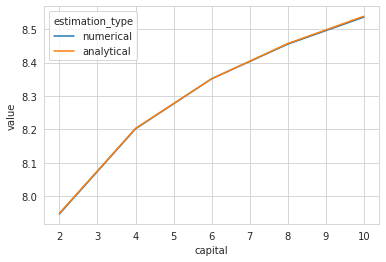

In [33]:
# first function call takes a bit longer than expected since it is compiled with
# numba. All following function calls are fast.
exercise(CAPITAL_GRID)

#### Exericse 1.11 and 1.12

In [36]:
CAPITAL_GRID = np.linspace(2, 10, num=1000)

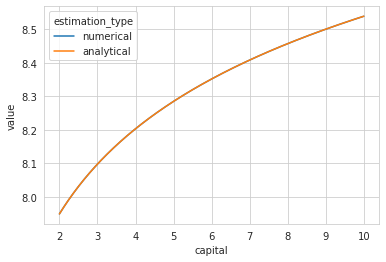

In [37]:
exercise(CAPITAL_GRID)